In [1]:
## Importing packages

# This R environment comes with all of CRAN and many other helpful packages preinstalled.
# You can see which packages are installed by checking out the kaggle/rstats docker image: 
# https://github.com/kaggle/docker-rstats

library(tidyverse) # metapackage with lots of helpful functions

## Running code

# In a notebook, you can run a single code cell by clicking in the cell and then hitting 
# the blue arrow to the left, or by clicking in the cell and pressing Shift+Enter. In a script, 
# you can run code by highlighting the code you want to run and then clicking the blue arrow
# at the bottom of this window.

## Reading in files

# You can access files from datasets you've added to this kernel in the "../input/" directory.
# You can see the files added to this kernel by running the code below. 

list.files(path = "../input")

## Saving data

# If you save any files or images, these will be put in the "output" directory. You 
# can see the output directory by committing and running your kernel (using the 
# Commit & Run button) and then checking out the compiled version of your kernel.

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0.9000     ✔ purrr   0.2.5     
✔ tibble  1.4.2          ✔ dplyr   0.7.6     
✔ tidyr   0.8.1          ✔ stringr 1.3.1     
✔ readr   1.2.0          ✔ forcats 0.3.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


character(0)

## Functions to be used

In [2]:
my.bootstrapci.ml <- function(vec0, nboot = 10000, alpha = 0.05){
  
    #extract sample size, mean and standard deviation from the original data
    n0 <- length(vec0)
    mean0 <- mean(vec0)
    sd0 <- sqrt(var(vec0))
      
    # create a vector to store the location of the bootstrap studentized deviation vector
    bootvec <- NULL
    bootbiasvec <- NULL
      
    #create the bootstrap distribution using a for loop
    for( i in 1:nboot){
        vecb <- sample(vec0, replace=T)
        
        #create mean and standard deviation to studentize
        meanb <- mean(vecb)
        sdb <- sqrt(var(vecb))
        
        #note since resampling full vector we can use n0 for sample size of vecb
        bootvec <- c(bootvec,(meanb-mean0)/(sdb/sqrt(n0)))
        
        #Calculation the vector that stores the bias of each bootstap sample
        bootbiasvec <- c(bootbiasvec, meanb-mean0)
      }

      
    bootbias <- mean(bootbiasvec)  
    bootsd <- mean(bootvec)
      
    #Calculate lower and upper quantile of the bootstrap distribution
    lq <- quantile(bootvec,alpha/2)
    uq <- quantile(bootvec,1-alpha/2)
      
    #incorporate into the bootstrap confidence interval (what algebra supports this?) and output result
    LB <- mean0-(sd0/sqrt(n0))*uq[[1]]
    UB <- mean0-(sd0/sqrt(n0))*lq[[1]]
      
    #since I have the mean and standard deviation calculate the normal confidence interval here as well
    NLB <- mean0-(sd0/sqrt(n0))*qnorm(1-alpha/2)
    NUB <- mean0+(sd0/sqrt(n0))*qnorm(1-alpha/2)
    
    list(bootbias = bootbias, bootsd = bootsd, bootstrap.confidence.interval=c(LB,UB),normal.confidence.interval=c(NLB,NUB))
}

In [3]:
Jackknife <- function(v1, statfunc = sd, alpha = 0.05){
      
    # Calculate length of a vector v1
    n1 <- length(v1)

    # Initialize an empty vector
    jackvec <- NULL
    
    # Calculate standard deviation of v
    mu0 <- statfunc(v1)
    
    for(i in 1:n1){
        
        # Find out standard deviation/or any stat function of all values in the vector except the ith element.
        # eg. for a vector c(1,2,3,4), sd(v[-1]) will calculate the standard deviation
        # of c(2,3,4).
        mua <- statfunc(v1[-i])
        
        # Calculate n*sigma for the new vector, subtract this from the original vector and append it in the list.
        jackvec <- c(jackvec, n1*(mu0) - (n1-1)*mua)
    }
      
    jackbias <- mean(jackvec) - mu0
    jacksd <- sd(jackvec)
    
    # Calculate the jacknife confidence intervals
    JLB <- mean(jackvec) - (jacksd/sqrt(n1))*qnorm(1-alpha/2)
    JUB <- mean(jackvec) + (jacksd/sqrt(n1))*qnorm(1-alpha/2)
    
    list(mu0=mu0,jackbias=jackbias,jacksd=jacksd, jackknife.confidence.interval = c(JLB, JUB))
}

## Question - 1

### 1.1 Confidence Interval Estimation using Bootstrap

In [4]:
my.bootstrapci.ml(1:1000)

$bootbias
[1] -0.009544

$bootsd
[1] -0.0008304439

$bootstrap.confidence.interval
[1] 482.3563 518.3596

$normal.confidence.interval
[1] 482.5991 518.4009

### 1.2 Bias and Standar Deviation Estimation using Jacknife

In [5]:
Jackknife(1:10000, statfunc = mean)

$mu0
[1] 5000.5

$jackbias
[1] 0

$jacksd
[1] 2886.896

$jackknife.confidence.interval
[1] 4943.918 5057.082

## Question - 2

### 2.1 Build a Simulator

In [6]:
simulation <- function(mu.val = 3, n = 30, nsim = 1000){

    #create coverage indicator vectors for bootstrap and normal
    cvec.boot <- NULL
    cvec.norm <- NULL
    cvec.jack <- NULL
    
  
    #calculate real mean
    mulnorm <- (exp(mu.val+1/2))

    #run simulation
    for(i in 1:nsim){
    
        if((i/100)==floor(i/100)){
          print(i)
        }
    
        #sample the simulation vector
        vec.sample <- rlnorm(n,mu.val)

        #bootstrap it
        boot.list <- my.bootstrapci.ml(vec.sample, nboot = 1000)

        #jackknife it
        jack.list <- Jackknife(vec.sample, statfunc = mean, alpha = 0.05)

        #fetch confidence intervals
        boot.conf <- boot.list$bootstrap.confidence.interval
        jack.conf <- jack.list$jackknife.confidence.interval
        norm.conf <- boot.list$normal.confidence.interval
    
        #calculate if confidence intervals include mu
        #count up the coverage by the bootstrap interval
        cvec.boot <- c(cvec.boot,(boot.conf[1]<mulnorm)*(boot.conf[2]>mulnorm))
        
        #count up the coverage by the jackknife interval
        cvec.jack <- c(cvec.jack,(jack.conf[1]<mulnorm)*(jack.conf[2]>mulnorm))

        #count up the coverage by the normal theory interval
        cvec.norm <- c(cvec.norm,(norm.conf[1]<mulnorm)*(norm.conf[2]>mulnorm))
    }
    
  #calculate and output coverage probability estimates
  list(boot.coverage = (sum(cvec.boot)/nsim), jack.coverage = (sum(cvec.jack)/nsim), norm.coverage = (sum(cvec.norm)/nsim))
}

## Question - 3
Due to computational contraints, I am using nboot as only 1000

### 3.1 Using n = 10

In [8]:
simulation(mu.val = 4, n = 10, nsim = 1000)

[1] 100
[1] 200
[1] 300
[1] 400
[1] 500
[1] 600
[1] 700
[1] 800
[1] 900
[1] 1000


$boot.coverage
[1] 0.891

$jack.coverage
[1] 0.778

$norm.coverage
[1] 0.778

### 3.2 Using n = 30

In [11]:
simulation(mu.val = 4, n = 30, nsim = 1000)

[1] 100
[1] 200
[1] 300
[1] 400
[1] 500
[1] 600
[1] 700
[1] 800
[1] 900
[1] 1000


$boot.coverage
[1] 0.915

$jack.coverage
[1] 0.865

$norm.coverage
[1] 0.865

### 3.3 Using n = 100

In [12]:
simulation(mu.val = 4, n = 100, nsim = 1000)

[1] 100
[1] 200
[1] 300
[1] 400
[1] 500
[1] 600
[1] 700
[1] 800
[1] 900
[1] 1000


$boot.coverage
[1] 0.937

$jack.coverage
[1] 0.908

$norm.coverage
[1] 0.908

## Question - 4

In [13]:
Jackknife_sd <- function(v1){
    n1 <- length(v1)
    jackvec <- NULL
    mu0 <- sd(v1)/n1
      
    for(i in 1:n1){
        mua <- sd(v1[-i])/(n1-1)
        jackvec <- c(jackvec, n1*(mu0)-(n1-1)*mua)
    }
      
    jackbias <- mean(jackvec) - mu0
    return (jackbias)
  } 

In [14]:
Bootstrap_sd <- function(vec0, nboot = 10000){
      
    #extract sample size, mean and standard deviation from the original data      
    n <- length(vec0)
    mean0 <- sd(vec0)/n
      
    bootvec <- NULL
    bootbiasvec <- NULL
      
    #create the bootstrap distribution using a for loop
    for(i in 1:nboot){
        
        vecb <- sample(vec0, replace = T)

        #create mean and standard deviation to studentize
        meanb <- sd(vecb)/n
        
        #note since resampling full vector we can use n0 for sample size of vecb
        bootvec <- c(bootvec, meanb)
        
        #Calculation the vector that stores the bias of each bootstap sample
        bootbiasvec <- c(bootbiasvec, meanb-mean0)
    }
      
    return(mean(bootbiasvec))  

}  

In [15]:
simulation_for_jackknife_and_bootstrap <- function(mu = 3, sd = 2, n = 30 , nsim = 4){
  
    #create coverage indicator vectors for bootstrap and normal
    bvec.boot <- NULL
    bvec.jack <- NULL
    
    #run simulation
    for(i in 1:nsim){
        
        if((i/100)==floor(i/100)){
          print(i)
        }
        
        #sample the simulation vector
        vec.sample <- rnorm(n, mean = mu, sd = sd)
        
        #bootstrap bias
        bvec.boot <- c(bvec.boot, Bootstrap_sd(vec.sample, nboot = 1000))
        
        #jackknife bias
        bvec.jack <- c(bvec.jack, Jackknife_sd(vec.sample))
    }
    
    list(boot_bias = bvec.boot, jack_bias = bvec.jack)  
  
}

In [16]:
Output_4 <- simulation_for_jackknife_and_bootstrap(mu = 3, sd = 2, n = 30 , nsim = 1000)
Output_4

[1] 100
[1] 200
[1] 300
[1] 400
[1] 500
[1] 600
[1] 700
[1] 800
[1] 900
[1] 1000


$boot_bias
   [1] -0.0018941001 -0.0020501418 -0.0018017297 -0.0012256249 -0.0014575366
   [6] -0.0016551564 -0.0011373431 -0.0013636511 -0.0015256367 -0.0017614606
  [11] -0.0018122462 -0.0015018215 -0.0014642118 -0.0016421830 -0.0017938311
  [16] -0.0019272789 -0.0015310705 -0.0012271204 -0.0018859254 -0.0016293266
  [21] -0.0012529216 -0.0010962772 -0.0012138135 -0.0018451937 -0.0014570791
  [26] -0.0010617626 -0.0018242177 -0.0019657066 -0.0011860552 -0.0013845232
  [31] -0.0014913223 -0.0012060276 -0.0018137667 -0.0013292484 -0.0012085223
  [36] -0.0015844636 -0.0015824114 -0.0016036676 -0.0024494547 -0.0021601835
  [41] -0.0011211757 -0.0016749004 -0.0014350541 -0.0012609956 -0.0016514105
  [46] -0.0009575190 -0.0015999480 -0.0014737221 -0.0013505519 -0.0009834063
  [51] -0.0017964950 -0.0009440929 -0.0015853308 -0.0015611491 -0.0022965332
  [56] -0.0016312188 -0.0017306980 -0.0012448538 -0.0013114258 -0.0016200213
  [61] -0.0014135330 -0.0012689026 -0.0018477189 -0.0013906110 -0.0019229687
  [66] -0.0015887214 -0.0013994747 -0.0015434934 -0.0011265269 -0.0019850063
  [71] -0.0013942149 -0.0016378169 -0.0015573182 -0.0014592534 -0.0010731212
  [76] -0.0013184520 -0.0014408628 -0.0011457007 -0.0016722608 -0.0012214257
  [81] -0.0013004601 -0.0020898285 -0.0014784960 -0.0019942401 -0.0025132347
  [86] -0.0014300538 -0.0016235016 -0.0016853391 -0.0010509979 -0.0015363105
  [91] -0.0012696584 -0.0014811598 -0.0021058534 -0.0013642482 -0.0010050138
  [96] -0.0012628484 -0.0018421066 -0.0021204549 -0.0012850247 -0.0013198484
 [101] -0.0017953139 -0.0016675680 -0.0016802751 -0.0013846997 -0.0015527208
 [106] -0.0036961894 -0.0015293928 -0.0018355872 -0.0019024770 -0.0015753925
 [111] -0.0017587568 -0.0018252410 -0.0014875199 -0.0022397085 -0.0013022549
 [116] -0.0014356728 -0.0012232809 -0.0017881034 -0.0020691690 -0.0012245037
 [121] -0.0014453862 -0.0019069009 -0.0012494232 -0.0014485597 -0.0009927459
 [126] -0.0015057951 -0.0014078340 -0.0016633292 -0.0014817192 -0.0022615177
 [131] -0.0026269024 -0.0015978118 -0.0014954363 -0.0016567665 -0.0017430622
 [136] -0.0015324321 -0.0011708779 -0.0023573871 -0.0010038770 -0.0020773540
 [141] -0.0011945742 -0.0013733336 -0.0013107200 -0.0016094356 -0.0021372774
 [146] -0.0016116664 -0.0019929914 -0.0017941551 -0.0016947724 -0.0010246117
 [151] -0.0012793785 -0.0011368610 -0.0018755393 -0.0013928631 -0.0019210488
 [156] -0.0015609920 -0.0015110085 -0.0018473244 -0.0016599420 -0.0009838501
 [161] -0.0015721038 -0.0018496733 -0.0022177679 -0.0013859350 -0.0011796182
 [166] -0.0017971549 -0.0017620981 -0.0014030935 -0.0011746639 -0.0016989356
 [171] -0.0015310764 -0.0012360053 -0.0022240907 -0.0015322672 -0.0015713845
 [176] -0.0017635355 -0.0015643645 -0.0018388748 -0.0008638008 -0.0017695806
 [181] -0.0019249863 -0.0025992858 -0.0018841740 -0.0011175609 -0.0010514354
 [186] -0.0012285999 -0.0018187647 -0.0012698520 -0.0021189921 -0.0013621834
 [191] -0.0015870184 -0.0011528131 -0.0014699717 -0.0015035445 -0.0013256779
 [196] -0.0012734746 -0.0018827115 -0.0021055833 -0.0014800414 -0.0012319628
 [201] -0.0012853425 -0.0017115119 -0.0014154668 -0.0012325323 -0.0015487137
 [206] -0.0024758356 -0.0018400281 -0.0018604953 -0.0023427907 -0.0018971561
 [211] -0.0018558598 -0.0020353635 -0.0012213391 -0.0018272762 -0.0012916357
 [216] -0.0014746523 -0.0012009156 -0.0015168449 -0.0010448719 -0.0028203421
 [221] -0.0013115249 -0.0013698805 -0.0022061426 -0.0019523753 -0.0012230996
 [226] -0.0023861174 -0.0010944457 -0.0016250283 -0.0022675242 -0.0015026271
 [231] -0.0010904196 -0.0017664428 -0.0011308083 -0.0015333564 -0.0018300325
 [236] -0.0017600032 -0.0013339616 -0.0021905677 -0.0017078928 -0.0018960418
 [241] -0.0021399879 -0.0013354110 -0.0017362409 -0.0007296116 -0.0011055218
 [246] -0.0015121341 -0.0016221825 -0.0022483979 -0.0013502530 -0.0014411807
 [251] -0.0020718508 -0.0026158951 -0.0015512919 -0.0016901216 -0.0019831306
 [256] -0.0015226725 -0.0013120936 -0.0017981694 -0.0020089570

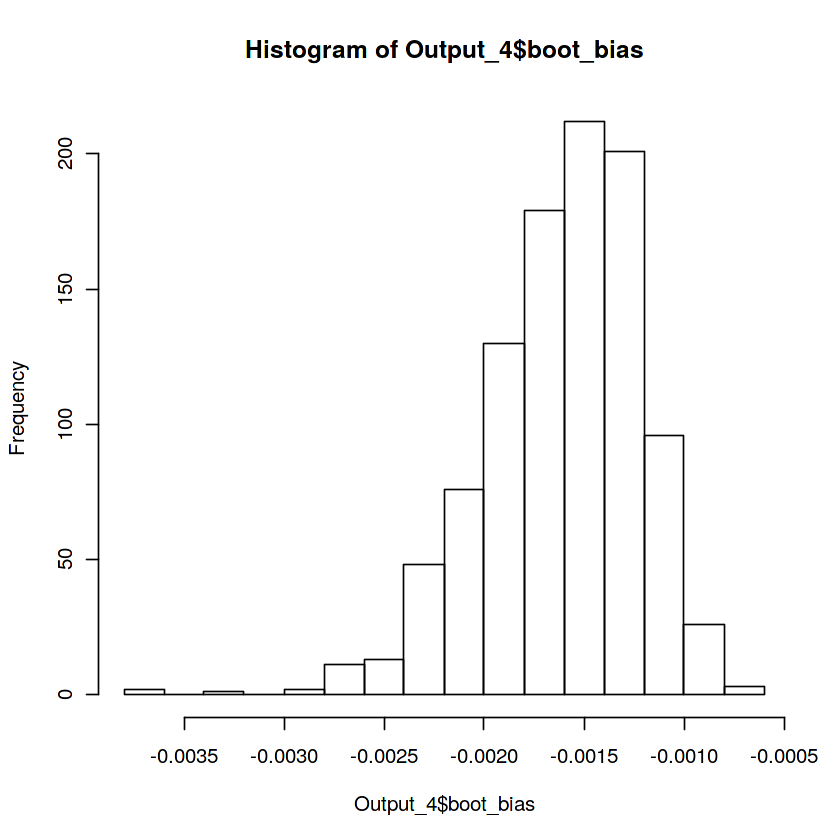

In [17]:
hist(Output_4$boot_bias)

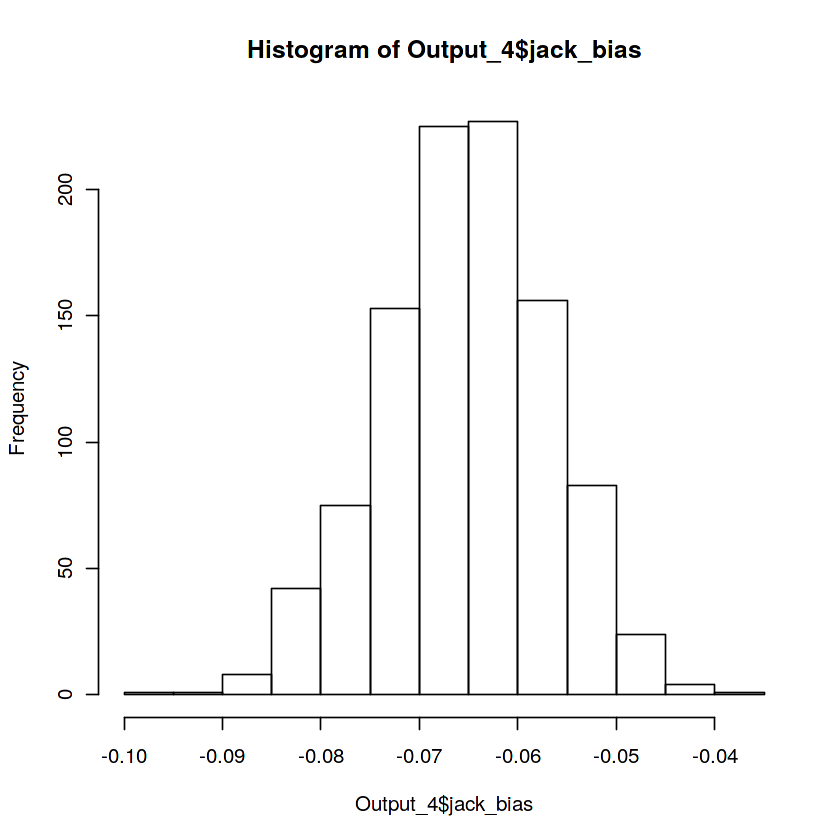

In [18]:
hist(Output_4$jack_bias)

We observe that the Jackknife bias histogram is normal. The bootstrap bias histogram is also somewhat normal but is a little skewed.